# 用于重新验证路径规划的结果

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import rasterio
from shapely import Point, LineString, Polygon
import shapely
import random
from enum import Enum
from rasterio.mask import mask
from CPP_Planner import CPP_Planner_Kit


In [2]:
matplotlib.rcParams['font.sans-serif'] = ['PingFang HK']
# hard-code 各个列表
swath_sep_indxes = [0, 28, 39, 49, 71]
# swath_sep_indxes = [17, 25, 39, 49, 71]
useful_land_indexes = [0, 4, 5, 6]
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）

# opti_path = '../PSO_opt_result/opt19/pso_result.csv'
opti_path = '../PSO_APF_analysis/opt16/pso_result.csv'
# opti_path = r'../PSO_APF_SMALL_LAND/opt5/pso_result.csv'
# real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
# straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
real_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp'
straight_swath_path_2 = r'GIS_data/路径规划优化用数据/all_swaths/straight_swaths_1_new.shp'
straight_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)
straight_swath_2 = gpd.read_file(straight_swath_path)
# straight_swath.iloc[7:9] = gpd.read_file(straight_swath_path_2).iloc[7:9]
straight_swath.iloc[5:18] = gpd.read_file(straight_swath_path_2).iloc[5:18]
# straight_swath = real_swath

all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
print(opti_parameters.shape)
print('straight and real swaths: ', len(straight_swath), end=' ')
print(len(real_swath))

with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_21.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:
#     slope_array = slope_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif') as curvature_src:
    curvature_array = curvature_src.read(1)

with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/dem_halfM_clip1.tif') as dem_src:
    dem_array = dem_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Aspect_halfM_clip1.tif') as aspect_src:
#     aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif') as slope_src:
    slope_array = slope_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Curvatu_halfM_clip1.tif') as curvature_src:
#     curvature_array = curvature_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape, curvature_array.shape]


(10, 6)
straight and real swaths:  71 71


/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54910/1793410378.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0002872 1.0002666 1.0007192 1.0007504 1.0002338 1.0002784 1.0001929
 1.0002103 1.000226  1.0002617 1.0004892 1.0005941 1.0005212]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  straight_swath.iloc[5:18] = gpd.read_file(straight_swath_path_2).iloc[5:18]


[(2025, 1767), (507, 442), (2025, 1767), (507, 440)]

In [3]:

land_ind = 0
single_land = CPP_Planner_Kit.get_single_shp(all_land, useful_land_indexes[land_ind])
# 选取特定的 swaths 进行演示
real_swath = real_swath[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
straight_swath = straight_swath[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
straight_swath_2 = straight_swath_2[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
print('Now swaths contains: {} swaths'.format(len(real_swath)))# 决定是否使用 道格拉斯普克 简化真实曲线

straight_swaths = []
for temp_line in real_swath.geometry:
    temp_simplified_line = temp_line.simplify(0.5, preserve_topology=False)
    straight_swaths.append(temp_simplified_line)
# straight_swath = gpd.GeoDataFrame(geometry=straight_swaths, crs=real_swath.crs)

# 计算地块内平均值和最小值
# slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
slope_src = rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif')
clip_slope_raster, _trans = mask(slope_src, single_land.geometry.values.tolist(), crop=True)
single_slope_mean = np.mean(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
single_slope_min = np.min(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
single_slope_median = np.median(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
[single_slope_mean, single_slope_min, single_slope_median]


Now swaths contains: 28 swaths


[8.674452, 0.0, 7.387925]

In [4]:
# 取出当前位置上的地形信息
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
def get_11_from_raster(point: Point, category):
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]


In [5]:

def model_fit(lambdas, data):
    # print(data, '1')
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    curvature = data[5]
    # x_off = lambdas[0] * np.cos(aspect) * slope
    # y_off = lambdas[1] * np.sin(aspect) * slope
    x_off = lambdas[0] * np.cos(aspect) * slope + lambdas[2] * curvature
    y_off = lambdas[1] * np.sin(aspect) * slope + lambdas[3] * curvature

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

def model_fit_2(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    curvature = data[5]
    # x_off = lambdas[0] * np.cos(aspect) * slope * vehicle_weight + lambdas[2] * (curvature / vehicle_wheel_width)
    # y_off = lambdas[1] * np.sin(aspect) * slope * vehicle_weight + lambdas[3] * (curvature / vehicle_wheel_width)
    x_off = lambdas[0] * np.cos(aspect) * slope * vehicle_weight + lambdas[2] * (np.abs(curvature) / vehicle_wheel_width)
    y_off = lambdas[1] * np.sin(aspect) * slope * vehicle_weight + lambdas[3] * (np.abs(curvature) / vehicle_wheel_width)

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

def model_fit_3(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    aspect = np.deg2rad(aspect)
    # slope_rad = np.deg2rad(slope)
    x_off = lambdas[0] * np.cos(aspect) * vehicle_weight * slope
    y_off = lambdas[1] * np.sin(aspect) * vehicle_weight * slope

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

# no triangle
def model_fit_4(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    curvature = data[5]
    # x_off = lambdas[0] * aspect * slope * vehicle_weight + lambdas[2] * (curvature / vehicle_wheel_width)
    # y_off = lambdas[1] * aspect * slope * vehicle_weight + lambdas[3] * (curvature / vehicle_wheel_width)
    x_off = lambdas[0] * aspect * slope * vehicle_weight + lambdas[2] * (np.abs(curvature) / vehicle_wheel_width)
    y_off = lambdas[1] * aspect * slope * vehicle_weight + lambdas[3] * (np.abs(curvature) / vehicle_wheel_width)

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

def model_fit_5(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    curvature = data[5]
    # print(data)
    # print(np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    # print(np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    # new_x = origin_x + np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * curvature) * vehicle_wheel_width / vehicle_weight
    # new_y = origin_y + np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * curvature) * vehicle_wheel_width / vehicle_weight
    new_x = origin_x + np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight + random.uniform(-0.1, 0.2)
    new_y = origin_y + np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight + random.uniform(-0.1, 0.2)
    # new_x = origin_x + np.abs(np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    # new_y = origin_y + np.abs(np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    return Point(new_x, new_y)


simulation begin
1222


/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54910/630776947.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_x = origin_x + np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight + random.uniform(-0.1, 0.2)
/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54910/630776947.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = origin_y + np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight + random.uniform(-0.1, 0.2)


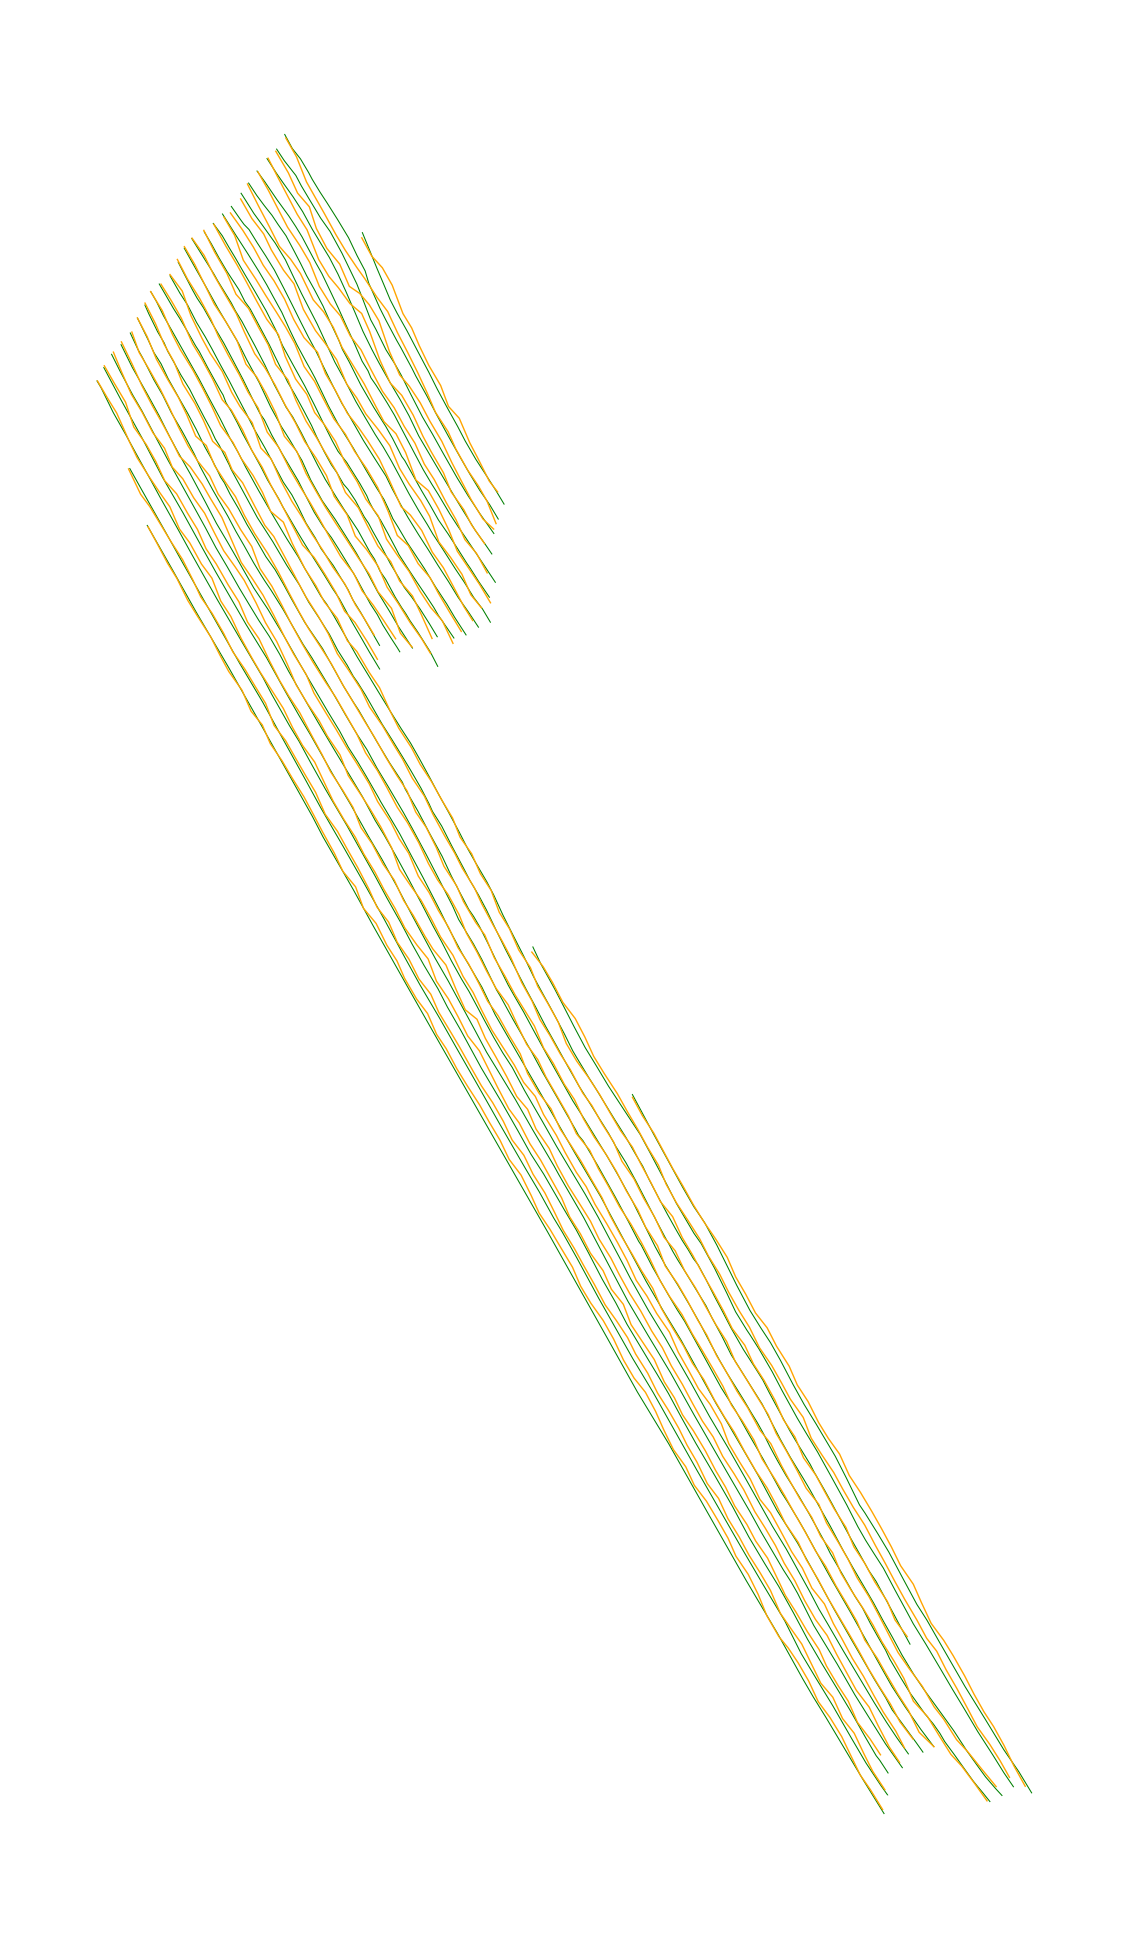

In [6]:
# %matplotlib qt
%matplotlib inline
optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmin()]
# optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmax()]
# optimal_params = [1, 1, 1, 1]

algor_gen_shp_path = r'../gen_paths/gen_02/gen_01.shp'
algor_gen_shp = gpd.read_file(algor_gen_shp_path)
# straight_swath = algor_gen_shp
# 查看所有的路径
_, ax = plt.subplots(dpi=500)
ax.set_axis_off()
ax.set_aspect('equal')
sample_accuracy = 2
# straight_swath.plot(ax=ax, color='black', linewidth=0.15)
# straight_swath_2.plot(ax=ax, color='black', linewidth=0.15)
real_swath.plot(ax=ax, color='g', linewidth=0.15)
# ax.plot(*all_land.geometry.iloc[useful_land_indexes[land_ind]].exterior.xy, color='y', linewidth=0.5)
# 制作一个数据表，分别是当前的模拟点，以及模拟点到最近真是路径的距离值
distance_points = []
point_counts = 0

all_distance_data = []
all_straight_distance_data = []
all_simulated_lines = []

# temp_save some training data for presentation
all_train_data = []

print('simulation begin')
for temp_real_line, temp_straight_line, temp_straight_line_2 in zip(real_swath.geometry, straight_swath.geometry, straight_swath_2.geometry):
    # samples = np.arange(0, temp_real_line.length, sample_accuracy)
    samples = np.arange(0, temp_straight_line.length, sample_accuracy)
    point_counts += len(samples)
    temp_result_points = []
    temp_distance_data = []
    temp_straight_distance_data = []
    for i, sample in enumerate(samples):
        # TODO: 找到问题所在
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_sample_point_2 = temp_straight_line_2.interpolate(sample)
        temp_point_data = [
            temp_sample_point.x, temp_sample_point.y,
            get_11_from_raster(temp_sample_point, raster.DEM),
            get_11_from_raster(temp_sample_point, raster.ASPECT),
            get_11_from_raster(temp_sample_point, raster.SLOPE),
            # abs(get_11_from_raster(temp_sample_point, raster.SLOPE) - single_slope_mean),
            # abs(get_11_from_raster(temp_sample_point, raster.SLOPE) - single_slope_median),
            get_11_from_raster(temp_sample_point, raster.CURVATURE)
        ]
        all_train_data.append(temp_point_data)
        # temp_simu_point = model_fit(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_2(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_3(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_4(optimal_params[1:], temp_point_data)
        temp_simu_point = model_fit_5(optimal_params[1:], temp_point_data)
        temp_result_points.append(temp_simu_point)
        # 计算距离
        temp_distance_data.append(temp_simu_point.distance(temp_real_line))
        # 计算直线上点的距离
        temp_straight_distance_data.append(temp_sample_point_2.distance(temp_real_line))
        # 添加路径点的数据
        distance_points.append({'GIS_info': temp_point_data, "simu_point": temp_simu_point, "real_dis": temp_simu_point.distance(temp_real_line)})
    all_distance_data.append(temp_distance_data)
    all_straight_distance_data.append(temp_straight_distance_data)
    # print(len(temp_result_points))
    temp_modi_line = LineString(temp_result_points)
    all_simulated_lines.append(temp_modi_line)
    ax.plot(*temp_modi_line.xy, color='orange', linewidth=0.2)
# straight_swath_2.plot(ax=ax, color='black', linewidth=0.15, linestyle='--')
# straight_swath_2.plot(ax=ax, color='black', linewidth=0.15, linestyle='-')
# plt.legend(['真实作业轨迹', '仿真作业路径'], loc='upper right', fontsize='small')
# plt.legend(['仿真前作业轨迹', '真实作业轨迹'], loc='upper right', fontsize='small')
# plt.legend(['real swath', 'straight swath', 'land boundary', 'simulation'])
# plt.legend(['origin path', 'real trajectory', 'simulation path'], fontsize=5)
# print('saving')
# plt.savefig('swath_simu.png', dpi=1000)
all_simulated_lines = gpd.GeoDataFrame(geometry=all_simulated_lines)
print(point_counts)

Text(0.5, 1.0, 'Average difference distance (m)')

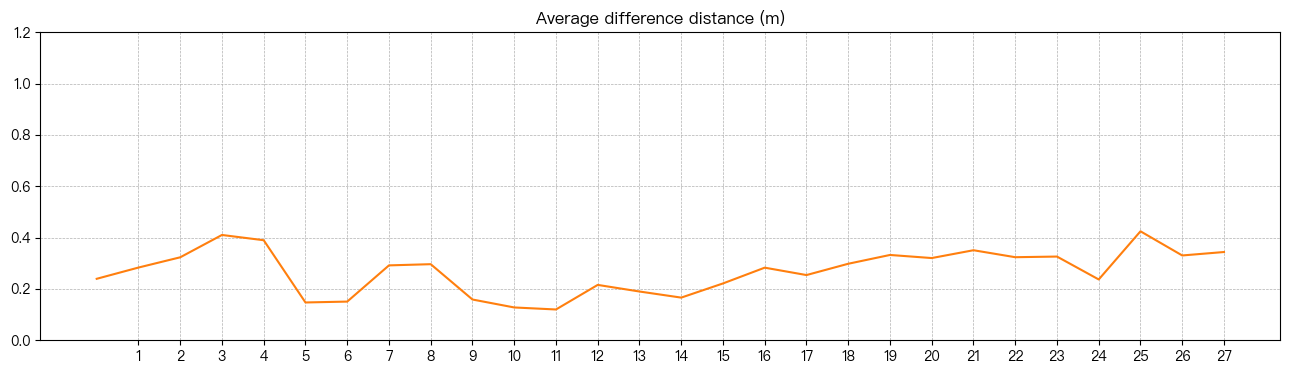

In [7]:
_, ax = plt.subplots(figsize=(16, 4))
all_average_distance = []
all_straight_average_distance = []
for line in all_distance_data:
    all_average_distance.append(np.mean(line))
for i, line in enumerate(all_straight_distance_data):
    if i in range(5, 9):
        all_straight_average_distance.append(np.mean(line)/3)
    else:
        all_straight_average_distance.append(np.mean(line))
    
ax.plot(all_average_distance)
ax.plot(all_straight_average_distance)
ax.grid(linestyle='--', linewidth=0.5)
# plt.legend(['average distance', 'average straight distance'])
plt.xticks(np.arange(1, len(real_swath), 1))
plt.ylim((0, 1.2))
plt.title("Average difference distance (m)")


0.04644448255162888


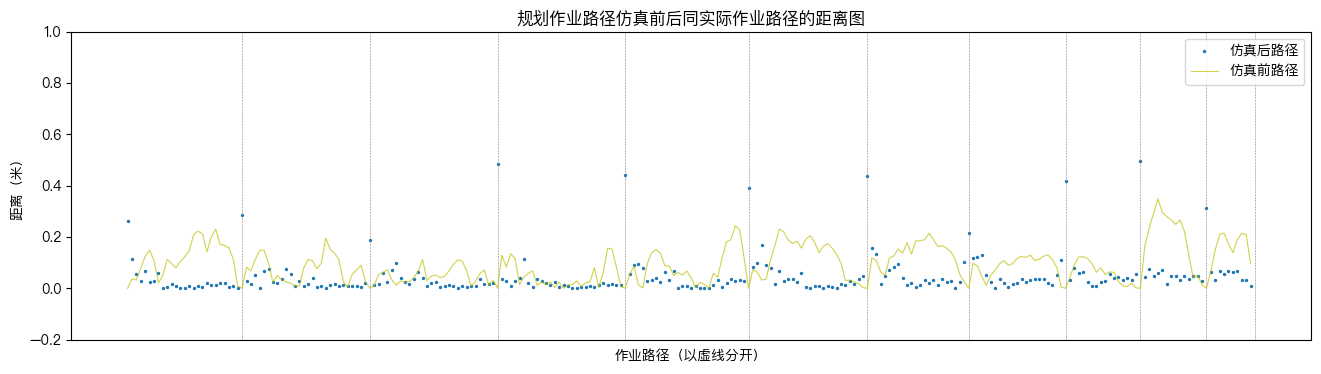

In [117]:
flatten_distances = []
flatten_straight_distances = []
flatten_gap = []
# 控制 plt 的长宽比为 4: 1
_, ax = plt.subplots(figsize=(16, 4))
ax.grid(False)
ax.set_facecolor('none')
# plt.figure(figsize=(16, 4))
for i in all_distance_data:
    flatten_distances += i
    flatten_gap.append(len(i))
for index, i in enumerate(all_straight_distance_data):
    if index in range(5, 7):
        flatten_straight_distances += np.divide(i, 1.5).tolist()
    elif index in range(7, 9):
        flatten_straight_distances += np.divide(i, 2.6).tolist()
    else:
        flatten_straight_distances += i
flatten_distances = np.array(flatten_distances)
# flatten_distances[flatten_distances >= 1] = 0
print(np.mean(flatten_distances))
plt.vlines(np.cumsum(flatten_gap), ymin=-0.2, ymax=2.5, colors="gray", linestyles="dashed", linewidth=0.4)
# plt.ylim((-0.2, 2))
plt.ylim((-0.2, 1))
# plt.plot(flatten_distances)
plt.scatter(range(len(flatten_distances)),flatten_distances, s=2, label='仿真后路径')
plt.plot(flatten_straight_distances, c='y', alpha=0.7, linewidth=0.8, label='仿真前路径')
# plt.scatter(range(len(flatten_straight_distances)),flatten_straight_distances, s=2)
# 在固定的 x 位置上显示竖直的虚线
# plt.title("all point difference distance (m)")
plt.title("规划作业路径仿真前后同实际作业路径的距离图")
plt.xlabel("作业路径（以虚线分开）")
plt.xticks([])
plt.ylabel("距离（米）")
plt.legend()
# saving
# import csv
# with open('opti_group.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(all_distance_data)
# 
# df_flatten_distances = pd.DataFrame(flatten_distances)
# df_flatten_distances.describe()

In [70]:
# import pickle
# with open(r'GIS_data/simul_points_info1.pkl', 'wb') as f:
#     pickle.dump(distance_points, f)


### 在论文中用，将当前的结果的 “正向优化和反向优化” 比较出来

In [71]:
all_distance_data_sub = []
for temp_strai, temp_data in zip(all_straight_distance_data, all_distance_data):
    temp_res = np.array(temp_strai) - np.array(temp_data)
    all_distance_data_sub.append(temp_res)
# 下面的变量是统计当前的所有路径的采样点的以路径为单位的优化情况，比如正向优化比负优化多或少，少多少？
all_distance_data_sub_flatten = []
for lst in all_distance_data_sub:
    length = len(lst)
    all_distance_data_sub_flatten += [np.sum(np.sign(lst) == 1) - np.sum(np.sign(lst) == -1) for i in range(length)]

Text(0, 0.5, '个数')

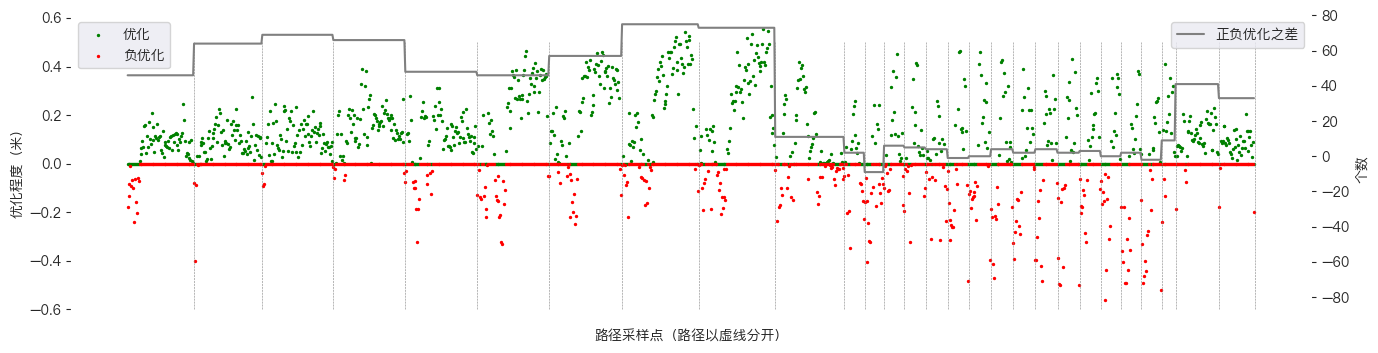

In [72]:
optimized_diff = np.array(flatten_straight_distances) - np.array(flatten_distances)

positive_part = optimized_diff.copy()
negative_part = optimized_diff.copy()
positive_part[positive_part < 0] = 0
negative_part[negative_part > 0] = 0

_, ax = plt.subplots(figsize=(16, 4))
ax.grid(False)
ax.scatter(range(len(positive_part)), positive_part, c='g', s=2, label='优化')
ax.scatter(range(len(negative_part)), negative_part, c='r', s=2, label='负优化')
ax.vlines(np.cumsum(flatten_gap), ymin=-0.6, ymax=0.5, colors="gray", linestyles="dashed", linewidth=0.4)
ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(all_distance_data_sub_flatten, c='gray', label='正负优化之差')
ax2.set_ylim(-95, 80)

ax.legend(loc='upper left')
ax.set_ylabel('优化程度（米）')
ax.set_xlabel('路径采样点（路径以虚线分开）')
ax.set_facecolor('none')
ax.set_xticks([])
ax2.legend(loc='upper right')
ax2.set_ylabel('个数')

In [12]:
distance_points[0]

{'GIS_info': [440345.93409065274,
  4397532.697626984,
  20572,
  98.36588,
  7.1756024,
  4.249954],
 'simu_point': <POINT (440345.932 4397532.338)>,
 'real_dis': 0.17983306770758972}

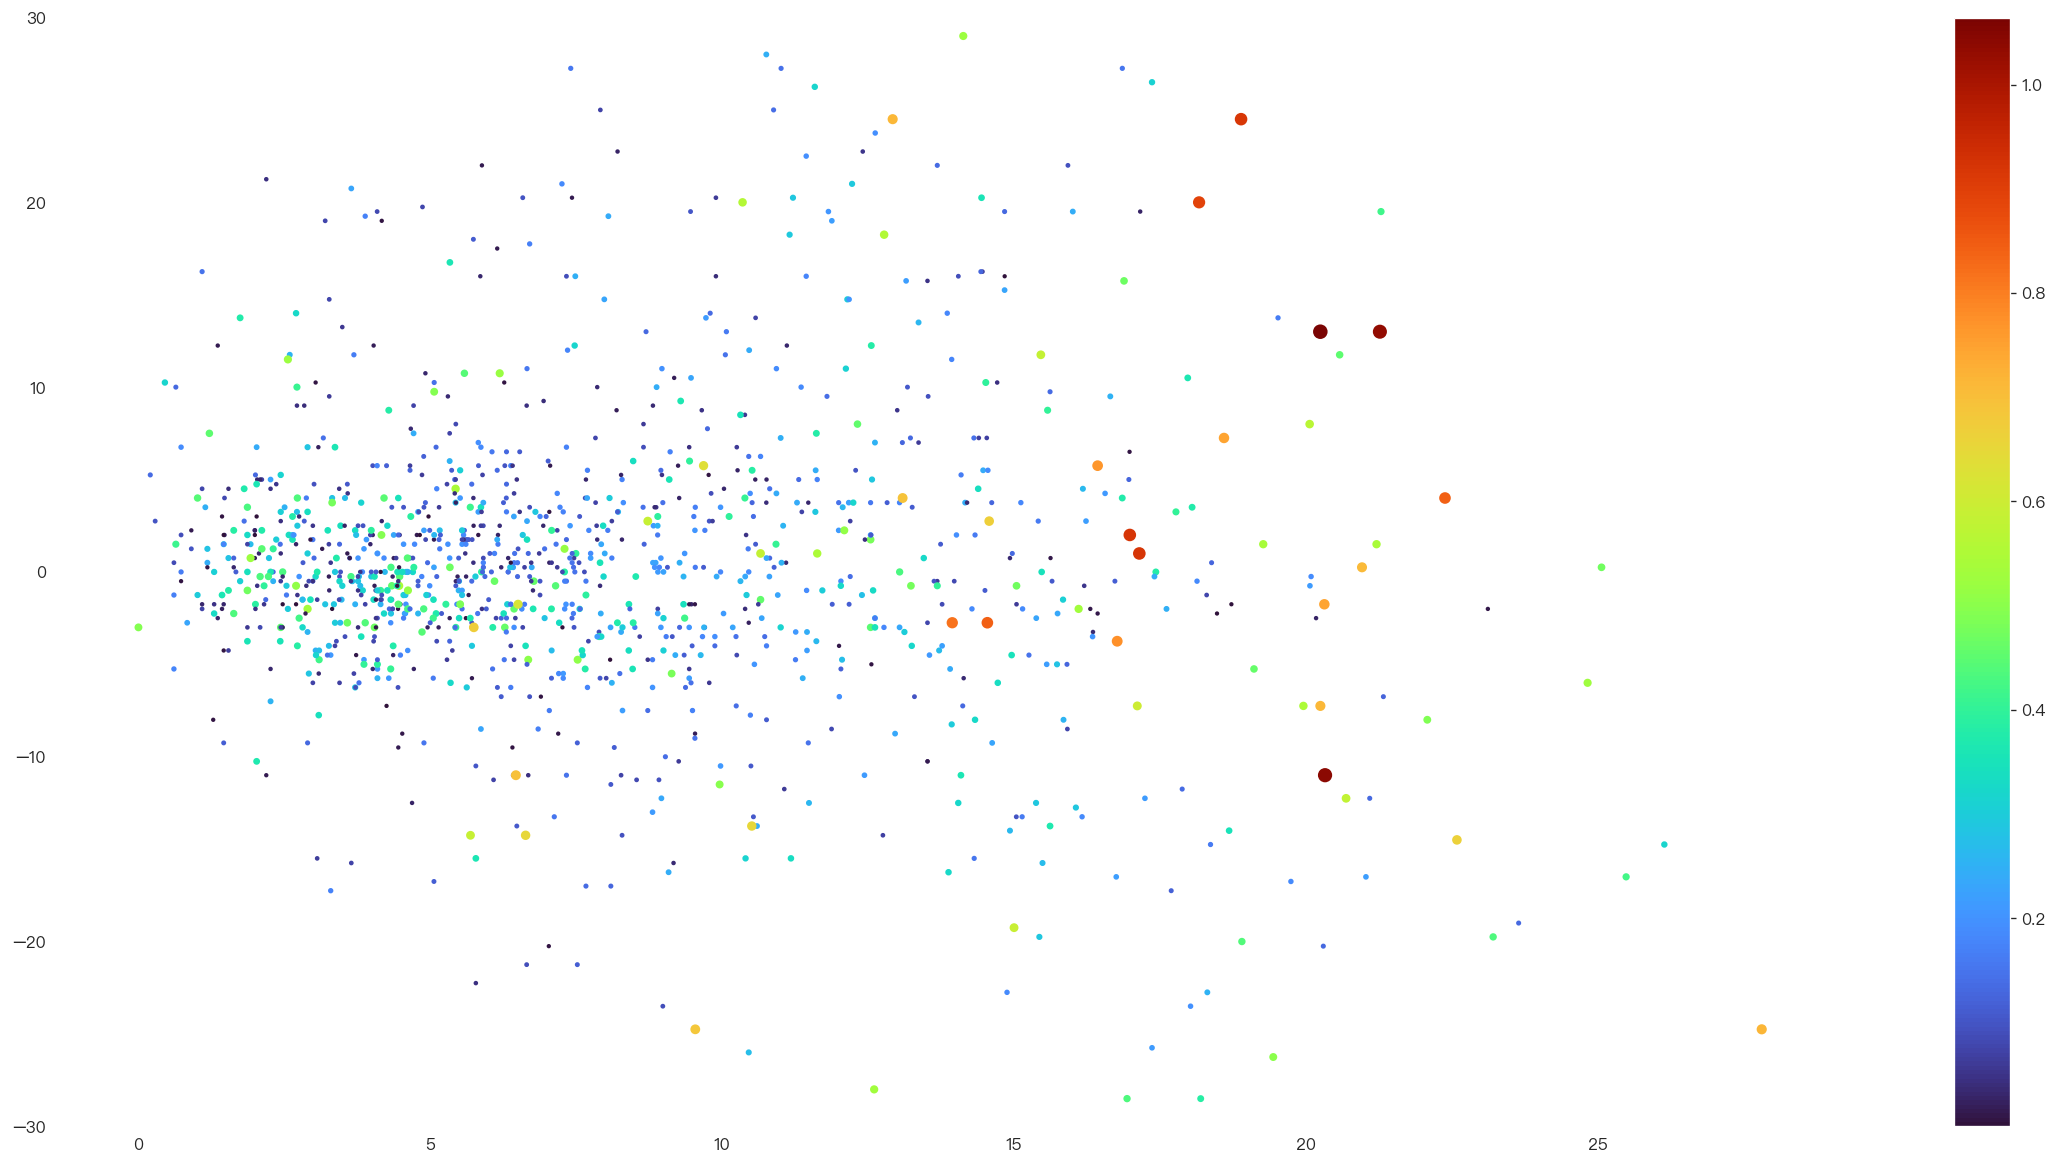

In [73]:
plt.figure(figsize=(24, 12), dpi=120)
plt.grid(False)
plt.gca().set_facecolor('none')
slope_data = []
curv_data = []
real_dis_data = []
for point in distance_points:
    slope_data.append(point['GIS_info'][4])
    curv_data.append(point['GIS_info'][5])
    real_dis_data.append(point['real_dis'])
plt.scatter(x=slope_data, y=curv_data, c=real_dis_data, s=(np.array(real_dis_data) + 1.2)**5, cmap='turbo')
plt.ylim(-30, 30)
plt.colorbar()


In [48]:
for average_distance in all_average_distance:
    # keep 2 digits after .
    print(f'{average_distance:.2f}', end=', ')
print(np.mean(all_average_distance))

0.18, 0.20, 0.22, 0.26, 0.30, 0.13, 0.10, 0.12, 0.14, 0.10, 0.14, 0.19, 0.13, 0.13, 0.16, 0.21, 0.24, 0.24, 0.30, 0.33, 0.33, 0.32, 0.32, 0.40, 0.34, 0.29, 0.23, 0.27, 0.22594516680817317


In [49]:
for i in range(29):
    print(i, end=', ')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 

In [13]:
# df_train = pd.DataFrame(all_train_data, columns=['point_x', 'point_y', 'DEM', 'Aspect', 'Slope', 'Curvature']).drop(columns='DEM')
# df_train.to_excel("APF_PSO_training_data.xlsx")